In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

from scipy.sparse import csr_matrix, csc_matrix
from scipy import sparse
from scipy.sparse.linalg import svds

In [3]:
# load data
users = pd.read_csv('../data/users.csv')
courses = pd.read_csv('../data/courses.csv')
user_reviews = pd.read_csv('../data/users.reviews.csv')

In [4]:
user_reviews.head()

,Unnamed: 0,_class,id,content,rating,created,modified,user_modified,user,course_id,user_id
0,0,course_review,136107616,NaN,5.0,2023-02-19T12:03:53-08:00,2023-02-20T15:05:30-08:00,2023-02-19T12:04:14-08:00,"{""_class"": ""user"", ""title"": ""Bexlcapital"", ""na...",473160,4426
1,1,course_review,136105174,NaN,5.0,2023-02-19T11:07:20-08:00,2023-02-20T15:05:30-08:00,2023-02-19T11:07:21-08:00,"{""_class"": ""user"", ""title"": ""Mr. Irshad"", ""nam...",473160,18314
2,2,course_review,136104456,NaN,5.0,2023-02-19T10:52:58-08:00,2023-02-20T15:05:30-08:00,2023-02-19T10:52:59-08:00,"{""_class"": ""user"", ""title"": ""Victoria Ferrario...",473160,28515
3,3,course_review,136100102,NaN,2.5,2023-02-19T09:29:38-08:00,2023-02-20T15:07:42-08:00,2023-02-19T09:29:42-08:00,"{""_class"": ""user"", ""title"": ""Beeran Ramdhari"",...",473160,4258
4,4,course_review,136099490,NaN,3.0,2023-02-19T09:18:22-08:00,2023-02-20T15:07:42-08:00,2023-02-19T09:18:25-08:00,"{""_class"": ""user"", ""title"": ""Paul Abass Kamara...",473160,20715


In [5]:
# Check number of rows and columns
rows, cols = user_reviews.shape
print('Number of rows: ', rows)
print('Number of columns: ', cols)

Number of rows:  33840
Number of columns:  11


In [6]:
# Check datatype
user_reviews.dtypes

Unnamed: 0         int64
_class            object
id                 int64
content           object
rating           float64
created           object
modified          object
user_modified     object
user              object
course_id          int64
user_id            int64
dtype: object

In [7]:
# Summary statistics of rating
user_reviews['rating'].describe().transpose()

count    33840.000000
mean         4.295464
std          0.958660
min          0.500000
25%          4.000000
50%          4.500000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

In [8]:
#Find the minimum and maximum ratings
print('Minimum rating is: %f' %(user_reviews.rating.min()))
print('Maximum rating is: %f' %(user_reviews.rating.max()))

Minimum rating is: 0.500000
Maximum rating is: 5.000000


In [9]:
# check for missing values
print('Number of missing values across columns: \n', user_reviews.isnull().sum())

Number of missing values across columns: 
 Unnamed: 0           0
_class               0
id                   0
content          26851
rating               0
created              0
modified             0
user_modified        0
user                 0
course_id            0
user_id              0
dtype: int64


# Rating

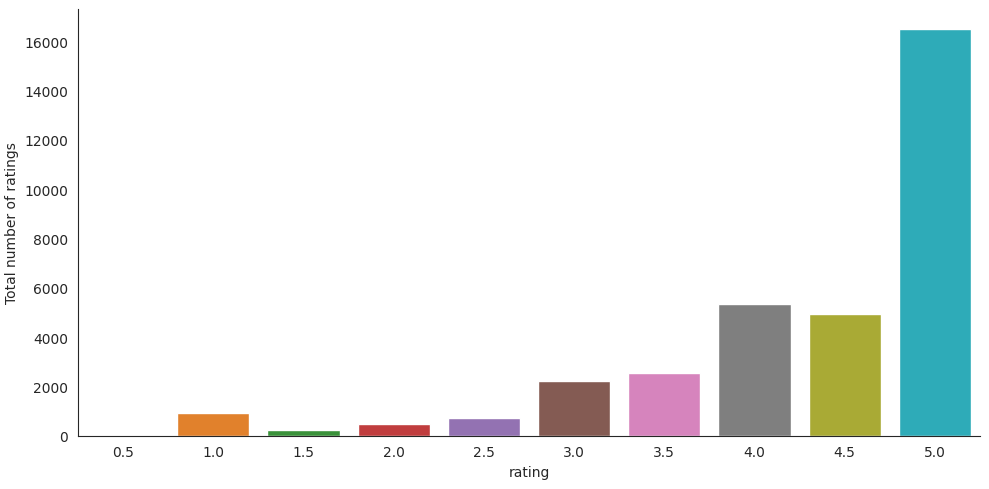

In [10]:
# Check the distribution of rating
with sns.axes_style('white'):
	g = sns.catplot(x="rating", data=user_reviews, aspect=2.0, kind='count')
	g.set_ylabels('Total number of ratings')

In [11]:
# Number of unique user id  in the data
print('Number of unique users in Raw data = ', user_reviews['user_id'].nunique())
# Number of unique product id  in the data
print('Number of unique product in Raw data = ', user_reviews['course_id'].nunique())

Number of unique users in Raw data =  29180
Number of unique product in Raw data =  3754


# Taking the subset of dataset to make it less sparse/denser

In [12]:
# Check top 10 users based on ratings
most_rated = user_reviews.groupby('user_id').size().sort_values(ascending=False)[:10]
print('Top 10 users based on ratings: \n', most_rated)

Top 10 users based on ratings: 
 user_id
2922     51
5311     30
28763    15
20538    12
16570    11
12654    11
6716     11
7464     10
16544    10
3085      9
dtype: int64


In [13]:
# ratings analysis in final dataset
rating_matrix = user_reviews.pivot_table(index='user_id', columns='course_id', values='rating').fillna(0)
rating_matrix.head()

course_id,1769,9711,10722,12226,15044,15639,16574,17503,20149,20600,...,5138882,5141272,5144368,5144642,5147396,5147840,5151386,5153286,5153476,5156284
user_id,,,,,,,,,,,,,,,,,,,,,
48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# Calucating the density of the rating marix
given_num_of_ratings = np.count_nonzero(rating_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = rating_matrix.shape[0] * rating_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

given_num_of_ratings =  31725
possible_num_of_ratings =  109541720
density: 0.03%


# Build popularity Recommender model

In [15]:
_test_df = pd.DataFrame({
	'user_id': [1, 1, 2, 3],
	'course_id': [1001, 1002, 1001, 1003],
	'rating': [3.5, 1.5, 4, 5]
})

_test_df.head()

,user_id,course_id,rating
0,1,1001,3.5
1,1,1002,1.5
2,2,1001,4.0
3,3,1003,5.0


In [16]:
Y_data = user_reviews[['user_id', 'course_id', 'rating']]
Y_data = Y_data.astype({'user_id': int, 'course_id': int, 'rating': float})
Y_data

,user_id,course_id,rating
0,4426,473160,5.0
1,18314,473160,5.0
2,28515,473160,5.0
3,4258,473160,2.5
4,20715,473160,3.0
...,...,...,...
33835,1914,5147840,5.0
33836,23639,5147840,5.0
33837,22923,5147840,5.0
33838,4141,5147840,5.0


In [17]:
num_users = len(Y_data['user_id'].unique())
num_courses = len(Y_data['course_id'].unique())
print('Num users: ', num_users)
print('Num courses: ', num_courses)

Num users:  29180
Num courses:  3754


In [18]:
# Matrix utility
matrix_utility = np.zeros((Y_data['user_id'].max(), ))
matrix_utility

array([0., 0., 0., ..., 0., 0., 0.])

In [19]:
# Ybar_data = Y_data.values.copy()
# Ybar_data = np.column_stack({
# 	Ybar_data[:, 0].astype(int),
# 	Ybar_data[:, 1].astype(int),
# 	Ybar_data[:, 2].astype(float)
# })
# Ybar_data

In [20]:
# normalize matrix
Ybar_data = Y_data.values.copy()
def normalize_matrix():
	user_ids = Y_data['user_id']
	for u_id in user_ids.unique():
		id_indexes = np.where(user_ids == u_id)[0].astype(np.int32)
		ratings = Ybar_data[id_indexes, 2]
		# calc avg
		m = np.mean(ratings)
		if np.isnan(m):
			m = 0
		#normalize
		Ybar_data[id_indexes, 2] = ratings - m
  
	# Create the sparse matrix
	print('Length of rows: ', len(Ybar_data[:, 1]))
	print('Length of cols: ', len(Ybar_data[:, 0]))
	print('Length of data: ', len(Ybar_data[:, 2]))
	num_rows, num_cols = Y_data.shape
	print(f'Shape of matrix: ({num_rows}, {num_cols})')
	Ybar = sparse.coo_matrix((Ybar_data[:, 2], (Ybar_data[:, 1].astype(np.int32), Ybar_data[:, 0].astype(np.int32))))
	Ybar_csr = csr_matrix(Ybar)
	del Ybar
	return Ybar_csr

In [21]:
Ybar_csr = normalize_matrix()
print(Ybar_csr)

Length of rows:  33840
Length of cols:  33840
Length of data:  33840
Shape of matrix: (33840, 3)
  (1769, 2177)	0.0
  (1769, 5297)	-0.25
  (1769, 5613)	0.0
  (1769, 7882)	0.0
  (1769, 9877)	0.0
  (1769, 16307)	0.0
  (1769, 19590)	0.0
  (1769, 23908)	0.0
  (1769, 24930)	0.0
  (1769, 29131)	0.0
  (9711, 1616)	0.0
  (9711, 4323)	0.0
  (9711, 11637)	0.0
  (9711, 17698)	0.0
  (9711, 21597)	0.0
  (9711, 22154)	0.0
  (9711, 22310)	0.0
  (9711, 22709)	0.0
  (9711, 23982)	0.0
  (9711, 28763)	-0.3666666666666667
  (10722, 3524)	0.0
  (10722, 5727)	0.0
  (10722, 7587)	0.0
  (10722, 7823)	0.0
  (10722, 10112)	0.0
  :	:
  (5147396, 17569)	0.0
  (5147396, 22598)	0.0
  (5147396, 27861)	0.0
  (5147840, 277)	0.0
  (5147840, 1914)	0.0
  (5147840, 4074)	0.0
  (5147840, 4141)	0.0
  (5147840, 19779)	0.0
  (5147840, 21483)	0.0
  (5147840, 22923)	0.0
  (5147840, 23639)	0.0
  (5147840, 27075)	0.0
  (5151386, 8672)	0.0
  (5151386, 10819)	0.0
  (5151386, 14108)	0.0
  (5151386, 14967)	0.0
  (5151386, 21075)	0.0


In [22]:
# calc similarity between user and item
def similarity():
    eps = 1*2.71828182846 - 6
    return cosine_similarity(Ybar_csr.T, Ybar_csr.T, dense_output=False)

In [23]:
user_sim = similarity()

In [24]:
print(user_sim[257])
# 2200 2465 

  (0, 26024)	0.37796447300922775
  (0, 25422)	-0.5000000000000013
  (0, 22114)	-0.5669467095138413
  (0, 10361)	0.5000000000000003
  (0, 3583)	-0.37796447300922775
  (0, 5311)	0.10352733788962418
  (0, 257)	1.0


In [84]:
# predict
def pred(user_id, course_id):
	# find all users who have rated this course
	rated_user_indexes = np.where(Y_data.values[:, 1] == course_id)[0].astype(np.int32)
	rated_user_ids = Y_data.values[rated_user_indexes, 0].astype(np.int32)
	sim = user_sim[(user_id, rated_user_ids)].toarray()[0]
	nearest_indexes = np.argsort(sim)[-3:]
	nearest_s = sim[nearest_indexes]
	r = Ybar_csr[(course_id, rated_user_ids[nearest_indexes])]
	return (r * nearest_s)[0] / (np.abs(nearest_s).sum() + 1e-8)

pred(257, 900694)

0.3427148230403418

In [93]:
def recommendTop(user_id, top_x):
	ids = np.where(Ybar_data[:, 0] == user_id)[0]
	courses_rated_by_u = Ybar_data[ids, 1].tolist()
	course = {'id': None, 'similar': None}
	list_courses = []
	
	def takeSimilar(elem):
		return elem['similar']

	for course_id in Y_data['course_id'].unique():
		if course_id not in courses_rated_by_u:
			rating = pred(user_id, course_id)
			course['id'] = course_id
			course['similar'] = rating
			list_courses.append(course.copy())
   
	sorted_courses = sorted(list_courses, key=takeSimilar, reverse=True)
	# sorted_courses.pop(top_x)
	return sorted_courses[:3]

recommendTop(257, 3)

[{'id': 887442, 'similar': 0.8666666248097702},
 {'id': 4600406, 'similar': 0.8666666248097702},
 {'id': 3067608, 'similar': 0.43333329147643856}]